(guide/dataframe/io)=

# I/O

In this guide, we will discuss how to bring data into Meerkat from various file formats and external libraries.  We will also discuss how to export data in Meerkat DataFrames back into these formats. Finally, we'll also discuss how to persist Meerkat DataFrames using {func}`~meerkat.DataFrame.write` and {func}`~meerkat.DataFrame.read`.

```{admonition} Should I export or persist?

This guide discusses two different ways of saving data in Meerkat: exporting and persisting.
They serve different purposes:
1. **Export** your DataFrame to another format using one of the `to_*` methods if you need to use the data with other libraries or tools. (See the section on {ref}`exporting`.)
2. **Persist** your DataFrame using {func}`~meerkat.DataFrame.write` if you simply want to save it to disk for later use. (See the section on {ref}`persisting`.)
```


```{contents}
:local:
```

## Importing DataFrames

Meerkat has a number of built-in functions for reading in data from various file formats and Python libraries. 
We'll provide one in depth example for reading in data from a CSV file, and then provide a list of the other supported file formats and libraries.

### *Example*: Importing a dataset from CSV

Let's load a CSV file from disk and read it into a Meerkat DataFrame. 
We will be using a small sample of data from the [National Gallery of Art Open Data Program](https://github.com/NationalGalleryOfArt/opendata). We've included this data at `_data/art_ngoa.csv` in the Meerkat repository.

We will use the {func}`~meerkat.from_csv` function to read in the data.

In [1]:
import meerkat as mk

df = mk.from_csv("_data/art_ngoa.csv")
df.head()

,title,attribution,medium,objectid,iiifthumburl
0,Boy with Cat,Ernst Ludwig Kirchner,lithograph on yellow wove paper,103631,"https://api.nga.gov/iiif/b309afc0-b270-4c29-9ce7-e8f39125f40d/full/!200,200/0/default.jpg"
1,A Hound Chasing a Hare,Benozzo Gozzoli,"pen and brown ink with traces of red chalk, heightened with white on pink prepared paper",75840,"https://api.nga.gov/iiif/6e53c5bd-799d-4ac8-a57d-2c831a57da14/full/!200,200/0/default.jpg"
2,"Lamp, Lower Portion","Anonymous Artist after Andrea Briosco, called Riccio",gilded bronze,130749,"https://api.nga.gov/iiif/8e5477ed-040f-4240-89ca-08d95b1c955b/full/!200,200/0/default.jpg"
3,Andiron with Putto Finial,Nicolò Roccatagliata,bronze,73441,"https://api.nga.gov/iiif/a6126402-696e-4333-96af-43362bef1afa/full/!200,200/0/default.jpg"
4,"Dispatch No. 4: THREE VALLEYS. The Valleys of Silicon, San Joaquin, and Death",Alec Soth,inkjet print and 48 page newsprint booklet in portfolio case,221224,"https://api.nga.gov/iiif/29e05dbf-f0e3-4088-9ffe-83d4ca8c1968/full/!200,200/0/default.jpg"


 Notice that each row corresponds to a single work of art, and each column corresponds to a different attribute of the work of art. 

 **Representing images.** The last column, `iiifthumburl`, contains a URL to a thumbnail image of the work.
Using {func}`~meerkat.image`, we can download the thumbnail image and display it in the DataFrame.

,image,title,attribution
0,,Boy with Cat,Ernst Ludwig Kirchner
1,,A Hound Chasing a Hare,Benozzo Gozzoli
2,,"Lamp, Lower Portion","Anonymous Artist after Andrea Briosco, called Riccio"
3,,Andiron with Putto Finial,Nicolò Roccatagliata
4,,"Dispatch No. 4: THREE VALLEYS. The Valleys of Silicon, San Joaquin, and Death",Alec Soth

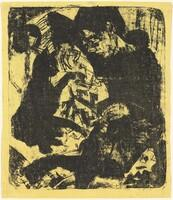
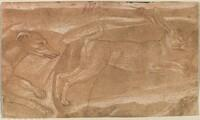
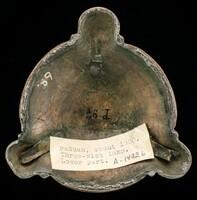
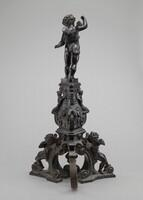
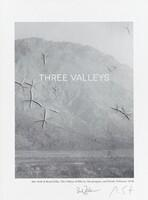

In [2]:
df["image"] = mk.image(df["iiifthumburl"], downloader="url")
df[["image", "title", "attribution"]].head()

The function `mk.image` creates a {class}`~meerkat.ImageColumn` which defers the downloading of images from the URLs until the data is needed. 

```{admonition} Deferred Columns
If you're wondering how {class}`~meerkat.ImageColumn` works, check out the guide on {doc}`column/deferred`. 
```

**Adding a primary key.** The `objectid` column contains a unique identifier for each work of art. We can use {func}`~meerkat.set_primary_key` to set this column as the primary key for the DataFrame, which allows us to perform key-based indexing on the DataFrame.

In [3]:
df = df.set_primary_key("objectid")
df.loc[221224]

{'title': 'Dispatch No. 4: THREE VALLEYS. The Valleys of Silicon, San Joaquin, and Death',
 'attribution': 'Alec Soth',
 'medium': 'inkjet print and 48 page newsprint booklet in portfolio case',
 'objectid': 221224,
 'iiifthumburl': 'https://api.nga.gov/iiif/29e05dbf-f0e3-4088-9ffe-83d4ca8c1968/full/!200,200/0/default.jpg',
 'image': FileCell(fn=<meerkat.columns.deferred.file.FileLoader object at 0x7f265819b460>)}

The {func}`~meerkat.from_csv` function has a utility parameter `primary_key` which can be used to set the primary key when the DataFrame is created.

In [4]:
mk.from_csv("_data/art_ngoa.csv", primary_key="objectid")

,title,attribution,medium,objectid,iiifthumburl
0,Boy with Cat,Ernst Ludwig Kirchner,lithograph on yellow wove paper,103631,"https://api.nga.gov/iiif/b309afc0-b270-4c29-9ce7-e8f39125f40d/full/!200,200/0/default.jpg"
1,A Hound Chasing a Hare,Benozzo Gozzoli,"pen and brown ink with traces of red chalk, heightened with white on pink prepared paper",75840,"https://api.nga.gov/iiif/6e53c5bd-799d-4ac8-a57d-2c831a57da14/full/!200,200/0/default.jpg"
2,"Lamp, Lower Portion","Anonymous Artist after Andrea Briosco, called Riccio",gilded bronze,130749,"https://api.nga.gov/iiif/8e5477ed-040f-4240-89ca-08d95b1c955b/full/!200,200/0/default.jpg"
3,Andiron with Putto Finial,Nicolò Roccatagliata,bronze,73441,"https://api.nga.gov/iiif/a6126402-696e-4333-96af-43362bef1afa/full/!200,200/0/default.jpg"
4,"Dispatch No. 4: THREE VALLEYS. The Valleys of Silicon, San Joaquin, and Death",Alec Soth,inkjet print and 48 page newsprint booklet in portfolio case,221224,"https://api.nga.gov/iiif/29e05dbf-f0e3-4088-9ffe-83d4ca8c1968/full/!200,200/0/default.jpg"
...,...,...,...,...,...
94,Mountain Landscape with a Hollow,Alexander Cozens,brush drawing in brown wash on laid paper,65569,"https://api.nga.gov/iiif/d26d1ba9-7814-4a7e-9d8b-1c0d24f76d7b/full/!200,200/0/default.jpg"
95,On the Vimy to Lens Road,David Young Cameron,watercolor and graphite,5708,"https://api.nga.gov/iiif/5e06918b-e6cb-4639-8452-2e050db3d2e9/full/!200,200/0/default.jpg"
96,Girl Writer,Ralph Austin,lithograph,148623,"https://api.nga.gov/iiif/57e15461-94b3-4020-8a8a-46884c2cc50d/full/!200,200/0/default.jpg"
97,"Jean de Saulx, 1555-1629, Viscount of Tavanes and Lugny, and Marquess of Mirabet [obverse]",French 17th Century,bronze,45344,"https://api.nga.gov/iiif/ccd2d7b2-6119-4326-aa04-cb61e28f11a3/full/!200,200/0/default.jpg"


```{admonition} Primary Keys
To learn more about primary keys and key-based indexing, check out the section {ref}`key-based-selection`. 
```

### Importing from storage formats
Meerkat supports importing data from a number of other file formats. As in the example above, you may need to set the primary key and/or add additional columns for complex data (*e.g.* images, audio).

- {func}`~meerkat.from_csv()`: Reads in data from a CSV (comma-separated values) file. CSV files are a common format for storing tabular data.

- {func}`~meerkat.from_feather()`: Reads in data from a [Feather file](https://arrow.apache.org/docs/python/feather.html). Feather is a language-agnostic file format for storing DataFrames. It can provide significantly faster I/O than CSV. 

- {func}`~meerkat.from_parquet()`: Reads in data from a [Parquet file](https://parquet.apache.org/). Parquet is a columnar storage format that is designed for efficiency. 

- {func}`~meerkat.from_json()`: Reads in data from a JSON file. 

If your data is in a format not listed here, load it into a Pandas DataFrame and use {func}`~meerkat.from_pandas()` to convert it to a Meerkat DataFrame.

### Importing from other libraries 
It's also posible to import data from third-party Python libraries like [Pandas](https://pandas.pydata.org/) and [HuggingFace Datasets](https://huggingface.co/datasets).

- {func}`~meerkat.from_pandas()`: Converts a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to a Meerkat DataFrame. By default, the index of the Pandas DataFrame will be used as the primary key for the Meerkat DataFrame.

- {func}`~meerkat.from_arrow()`: Converts an [Arrow Table](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table) to a Meerkat DataFrame.


- {func}`~meerkat.from_huggingface()`: Converts a HuggingFace Dataset to a Meerkat DataFrame. By default, the index of the HuggingFace Dataset will be used as the primary key for the Meerkat DataFrame.


(exporting)=
## Exporting DataFrames
Meerkat supports exporting DataFrames from Meerkat to other file formats and libraries. These methods are useful for converting data into formats that can be used by other libraries or software.

```{warning}

Most file formats designed for tabular data do not offer the same flexibility as Meerkat DataFrames, especially when it comes to storing complex data types and multi-dimensional tensors. As a result, exporting a Meerkat DataFrame to a file format may result in data loss.

Specifically, any {class}`~meerkat.DeferredColumn` (or its subclasses) will not be exported. If you want to export a {class}`DeferredColumn`, you should first materialize the column(s) by calling the DataFrame. Also, depending on the export destination, any {class}`~meerkat.TensorColumn` and/or {class}`~meerkat.ObjectColumn` in the DataFrame may not be exported.
```

If you simply want to save a Meerkat DataFrame to disk, you should use {func}`~meerkat.DataFrame.write()` instead (see {ref}`writing-dataframes`). This will persist the DataFrame in a format that can be read back into Meerkat without any data loss.

Continuing with the example above, let's export the DataFrame to a CSV file.

In [5]:
df.to_csv("_data/art_ngoa_export.csv")

/home/runner/work/meerkat/meerkat/meerkat/dataframe.py:901: UserWarning: Could not convert column image of type <class 'meerkat.columns.deferred.file.FileColumn'>, it will be dropped from the output.
  warnings.warn(


If we inspect the first 5 lines of the CSV file from the command line, we can see that the `image` column is missing. This is because the `image` column is a {class}`~meerkat.DeferredColumn` and was not exported.

In [6]:
!head -n 5 _data/art_ngoa_export.csv

title,attribution,medium,objectid,iiifthumburl
Boy with Cat,Ernst Ludwig Kirchner,lithograph on yellow wove paper,103631,"https://api.nga.gov/iiif/b309afc0-b270-4c29-9ce7-e8f39125f40d/full/!200,200/0/default.jpg"
A Hound Chasing a Hare,Benozzo Gozzoli,"pen and brown ink with traces of red chalk, heightened with white on pink prepared paper",75840,"https://api.nga.gov/iiif/6e53c5bd-799d-4ac8-a57d-2c831a57da14/full/!200,200/0/default.jpg"
"Lamp, Lower Portion","Anonymous Artist after Andrea Briosco, called Riccio",gilded bronze,130749,"https://api.nga.gov/iiif/8e5477ed-040f-4240-89ca-08d95b1c955b/full/!200,200/0/default.jpg"
Andiron with Putto Finial,Nicolò Roccatagliata,bronze,73441,"https://api.nga.gov/iiif/a6126402-696e-4333-96af-43362bef1afa/full/!200,200/0/default.jpg"


When columns are dropped during export, a warning is raised.

### Exporting to storage formats

Meerkat supports exporting DataFrames to a number of file formats, with the {class}`~meerkat.DataFrame` class providing the methods listed below. 

- {func}`~meerkat.DataFrame.to_csv()`: Writes the DataFrame to a CSV file. CSV files are a common format for storing tabular data. Unlike some alternatives, CSV files are human-readable in a text-editor and can be easily imported into spreadsheet software.
- {func}`~meerkat.DataFrame.to_feather()`: Writes the DataFrame to a [Feather file](https://arrow.apache.org/docs/python/feather.html). Feather is a language-agnostic file format for storing DataFrames. It can provide significantly faster I/O than CSV.
- {func}`~meerkat.DataFrame.to_parquet()`: Writes the DataFrame to a [Parquet file](https://parquet.apache.org/). Parquet is a columnar storage format that is designed for efficiency.
- {func}`~meerkat.DataFrame.to_json()`: Writes the DataFrame to a JSON file.

Note that several of the methods take an optional `engine` parameter. This parameter allows you to control the underlying library that is used to write the DataFrame to disk. Options include: `pandas` and `arrow`. If no `engine` is specified, one is automatically chosen based on the columns in the DataFrame. For example, we can write the DataFrame to a CSV file using the Arrow library instead of Pandas.

In [7]:
df.to_csv("_data/art_ngoa_export_arrow.csv", engine="arrow")

### Exporting to other libraries

It is also possible to export Meerkat DataFrames to other Python DataFrame libraries. 

- {func}`~meerkat.DataFrame.to_pandas()`: Converts the DataFrame to a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
- {func}`~meerkat.DataFrame.to_arrow()`: Converts the DataFrame to an [Arrow Table](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table).

(persisting)=
## Persisting DataFrames
In this section, we discuss how to persist Meerkat DataFrames to disk using the {func}`~meerkat.DataFrame.write()` method. Unlike the export methods discussed above, {func}`~meerkat.DataFrame.write()` guarantees that the DataFrame read back in with {func}`~meerkat.read` will contain the exact sam columns as the original DataFrame.
(writing-dataframes)=
### Writing DataFrames 
Above we saw how some column types in Meerkat DataFrames cannot be exported to a single file format. Specifically, we saw that the column we created to display images was dropped when exporting to CSV.

{func}`~meerkat.DataFrame.write` allows us to persist the DataFrame to disk in a way that will preserve the image column.

In [8]:
df.write("_data/art_ngoa.mk")

*How does it work?* Under the hood, {func}`~meerkat.DataFrame.write` works by splitting the DataFrame among several different files. For example, the {class}`~meerkat.ScalarColumn`s could be stored together in a [Feather file](https://arrow.apache.org/docs/python/feather.html), while the {class}`~meerkat.TensorColumn`s could be stored in [NPY format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html#module-numpy.lib.format). The path passed to {func}`~meerkat.DataFrame.write` is the directory where the files will be stored. The directory will also contain a `meta.yaml` file that contains information about the DataFrame. This file is used by {func}`~meerkat.read()` to reconstruct the DataFrame.

### Reading DataFrames 
To read the DataFrame back in from disk, we can use the {func}`~meerkat.read()` function.

,title,attribution,medium,objectid,iiifthumburl,image
0,Boy with Cat,Ernst Ludwig Kirchner,lithograph on yellow wove paper,103631,"https://api.nga.gov/iiif/b309afc0-b270-4c29-9ce7-e8f39125f40d/full/!200,200/0/default.jpg",
1,A Hound Chasing a Hare,Benozzo Gozzoli,"pen and brown ink with traces of red chalk, heightened with white on pink prepared paper",75840,"https://api.nga.gov/iiif/6e53c5bd-799d-4ac8-a57d-2c831a57da14/full/!200,200/0/default.jpg",
2,"Lamp, Lower Portion","Anonymous Artist after Andrea Briosco, called Riccio",gilded bronze,130749,"https://api.nga.gov/iiif/8e5477ed-040f-4240-89ca-08d95b1c955b/full/!200,200/0/default.jpg",
3,Andiron with Putto Finial,Nicolò Roccatagliata,bronze,73441,"https://api.nga.gov/iiif/a6126402-696e-4333-96af-43362bef1afa/full/!200,200/0/default.jpg",
4,"Dispatch No. 4: THREE VALLEYS. The Valleys of Silicon, San Joaquin, and Death",Alec Soth,inkjet print and 48 page newsprint booklet in portfolio case,221224,"https://api.nga.gov/iiif/29e05dbf-f0e3-4088-9ffe-83d4ca8c1968/full/!200,200/0/default.jpg",
...,...,...,...,...,...,...
94,Mountain Landscape with a Hollow,Alexander Cozens,brush drawing in brown wash on laid paper,65569,"https://api.nga.gov/iiif/d26d1ba9-7814-4a7e-9d8b-1c0d24f76d7b/full/!200,200/0/default.jpg",
95,On the Vimy to Lens Road,David Young Cameron,watercolor and graphite,5708,"https://api.nga.gov/iiif/5e06918b-e6cb-4639-8452-2e050db3d2e9/full/!200,200/0/default.jpg",
96,Girl Writer,Ralph Austin,lithograph,148623,"https://api.nga.gov/iiif/57e15461-94b3-4020-8a8a-46884c2cc50d/full/!200,200/0/default.jpg",
97,"Jean de Saulx, 1555-1629, Viscount of Tavanes and Lugny, and Marquess of Mirabet [obverse]",French 17th Century,bronze,45344,"https://api.nga.gov/iiif/ccd2d7b2-6119-4326-aa04-cb61e28f11a3/full/!200,200/0/default.jpg",

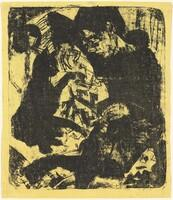
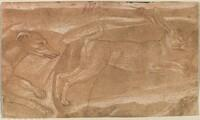
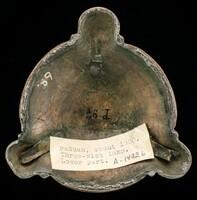
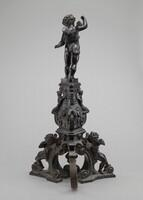
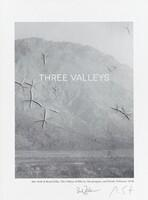
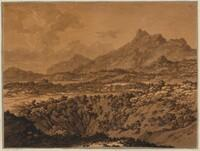
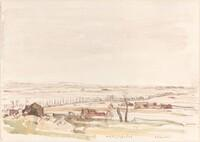
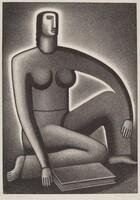
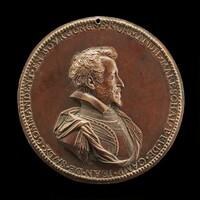
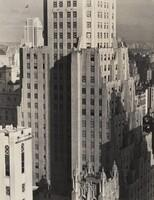

In [9]:
mk.read("_data/art_ngoa.mk")

Note that all the columns are present, including the `image` column, which had previously been lost with {func}`~meerkat.DataFrame.to_csv`.